<a href="https://colab.research.google.com/github/steve-wilson/nlpcss201-sm-preprocessing/blob/main/NLPCSS_TweetPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Media Preprocessing
### NLP+CSS 201, March 17, 2022
##### [Steve Wilson](https://steverw.com), Assistant Professor of Computer Science,<br/> Oakland University, Rochester, Michigan

This notebook can be accessed at: https://bit.ly/nlpcss201-preproc

👉 To get started, select File -> Open in playground mode


# 0. Setup 🛠

### Imports and installs

Click run ▶️ to install libraries, download data, and define some functions that we will use.

While you are waiting for that to finish, you can move to section 1. 

In [ ]:
# imports
import collections
import math
import random
import re
import requests
import sklearn
import string
import urllib

# some NLP libraries that can help us with preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# for coloring out outputs
from termcolor import colored
# for comparing strings
import difflib

import pandas as pd
from bs4 import BeautifulSoup

! pip install spacymoji
import spacymoji

! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm

import spacy
! pip install tweet_preprocessor
import preprocessor as tweet_preprocessor
! pip install twitter-text-python
from ttp import ttp
! pip install emoji
import emoji
! pip install ekphrasis
import ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

# get dataset from github
dataset_url = "https://raw.githubusercontent.com/steve-wilson/nlpcss201-sm-preprocessing/main/celebrity_tweets_no_rts.csv"
r = requests.get(dataset_url)
with open('celebrity_tweets.csv','wb') as output_file:
  output_file.write(r.content)

#### Before and after: a helper function 🕵

If you just want to use this rather than see how it works, click run and move on.

#### Function definition


`before_and_after(text, processing_function)`<br/>
- Process a text and highlight what changed.

  -   `text` (String): the text to process
  - `processing_function` (callable): the function to use to process `text`
    - should take a String as input and return a String or list of Strings (tokens)



Don't worry about understanding this code now, just click run to create the function (but you can check if you are curious!)

In [ ]:
# Let's define a function that lets us examine the effects of processing
# We will pass the text to process, and the processing method we want to use
def before_and_after(text, method, kwargs={}):

  # get the before and after, then compare them with difflib's SequenceMatcher
  before = text
  after = method(text,**kwargs)
  if type(after) == list:
    after = ' '.join(after)
  diffs = difflib.SequenceMatcher(None, before, after)

  # This part takes a string and some sections that do match the other string
  # but highlights the parts that *don't* match
  def print_highlight_nonmatching(text, text_id, matches, hl_func):
    current = 0
    for match in matches:
      nonmatching_count = match[text_id] - current
      # some part of the string didn't match the other, 
      # need to print it with hl_func
      if nonmatching_count:
        substring_end = current + nonmatching_count
        print(hl_func(text[current:substring_end]),end='')
        current = substring_end
      # now print the part that *did* match without any color effects
      substring_end = current + match.size
      print(text[current:substring_end],end='')
      current = substring_end
    # print a blank line between the two
    print()

  # this will get the sequences that did match between the two strings
  matches = diffs.get_matching_blocks()
  hl_func_red = lambda x: colored(x,'red')
  hl_func_blue = lambda x: colored(x,'blue')

  # now use this to show the before and after with changes highlighted
  print("BEFORE: ",end="")
  print_highlight_nonmatching(before, 0, matches, hl_func_red)
  print("AFTER:  ",end="")
  print_highlight_nonmatching(after, 1, matches, hl_func_blue)

#### Example usage

In [ ]:
# And just to try it out quickly, let's define a function to process text with
def my_lowercasing_function(text):
  return text.lower()

# Then apply our function to the text using the before_and_after function
song_title = "It's a beautiful day for some NLP!"
before_and_after(song_title, my_lowercasing_function)

# 1. Introduction

- Many traditional text preprocesing pipelines include steps that remove things like:

| feature to remove | examples |
----------|-----------
| Special characters | ' } { [ ] # @ ! * < > ~ |
| Out of vocabulary words | icebucketchallenge, wowwwww |
| Emoji | 👾🙏🏴󠁧󠁢󠁳󠁣󠁴󠁿🤷🏽🥰 |
| URLs | https://colab.research.google.com | 
| known social media features | @mentions, RT, #hashtags |
| nonstandard casing | YIKES, dO sOMe PrEpROceSSinG

- In other cases, these aren't removed, but rather replaced with standard tokens like \<URL\> or \<OOV\>

- This can be useful if your goal is to *only* consider "standard" language features in your analysis/modeling

- What kinds of information do you think the features in the table above actually might encode?

- Today we are going to talk about:
  - What you might be missing if you take that approach
  - Alternative approaches you can take to handling these features
  - Considerations for when you might want to take each approach

## Preview

### Emoji 😁

What if instead of removing emoji, we used them in our analysis?

- Did you know that many emoji are compositional and we can extract the individual elements?
  - e.g., 🧑🏽‍🔬 = 🧑 + 🏽 + 🔬
    - 🧑 person
    - 🏽 medium skin tone
    - 🔬 microscope

In this tutorial, we will show how you can process text to find what is the most common skin tone modifier used by each user in a corpus of tweets, and how often they used it in a sample of tweets, leading to a result like this:

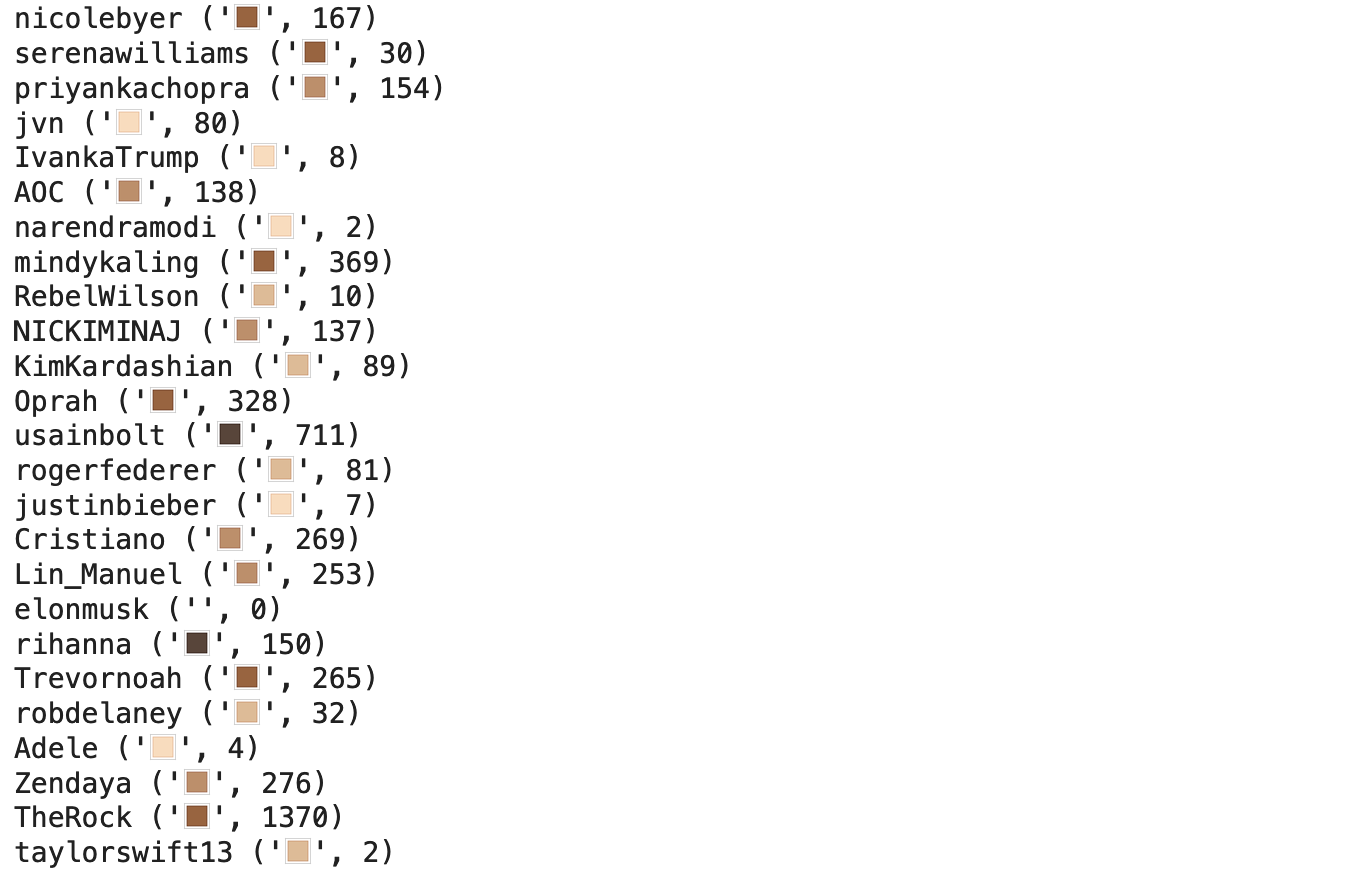

We will also show how to convert emojis into plain text descriptions, like:
- 🍕 -> pizza
- 🐭 -> mouse face
- 🍡 -> dango

Which has been shown to improve classification performance ([Singh et al., 2019](https://aclanthology.org/N19-1214/))!

### #Hashtags

What if instead of just removing the # (or the entire token), we considered the words within a hashtag?
- We can use a classic sequence analysis algorithm ([Viterbi, 1967](https://ieeexplore.ieee.org/document/1054010), [see A.4 here](https://web.stanford.edu/~jurafsky/slp3/A.pdf)) to find the most likely combination of words within hashtags!

Later, we will show how to go from:
- #whataday -> what a day
- #herewegoagain -> here we go again
- #iamvaccinated -> i am vaccinated

### https:// URLs .com

What if instead of remove URLs, we tried to extract useful information from them?
- We can parse the URL strings to gather important pieces, or even retrieve the text from the webpages themselves!

Today we'll show how to easily:
- Extract domains, e.g., given:
  - https://www.nytimes.com/live/2022/03/16/world/ukraine-russia-war#who-is-volodymyr-zelensky-the-comic-turned-wartime-leader-of-ukraine
  - extract: nytimes.com
- Retrieve text, e.g., given:
  - https://www.cdc.gov/coronavirus/2019-ncov/vaccines/vaccine-benefits.html?s_cid=10466:should%20i%20vaccinate:sem.ga:p:RG:GM:gen:PTN:FY21
  - extract: "Getting vaccinated against COVID-19 can lower your risk of getting and spreading the virus that causes COVID-19. Vaccines can also help prevent serious illness and death..." (and so on)

## Tutorial goals

In this tutorial, you will learn:

- Which **features of social media text** pose challenges for traditional preprocessing pipelines
- Several **approaches** that can be used to handle common social media phenomena
- How to use **Python code** to implement these approaches

and you will have a chance to try everything out and practice along the way!

## Quick Links

Tools/libraries we will talk about today:
- NLTK
- Pandas
- Beautiful Soup
- SpaCy
- Spacymoji
- emoji library
- Ekphrasis
- Twitter-text python
- Tweet preprocessor
- Twitter celebrity dataset from March 2022

Resources for learning more about text preprocessing (non-social-media) basics:
- [Processing Raw Text](https://www.nltk.org/book/ch03.html) from the NLTK Book
- [Working with Text Data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html) in scikit-learn
- [Day 3: Automated Text Analysis](https://sicss.io/curriculum) from SICSS
- [Regular Expressions, Text Normalization, Edit Distance](https://web.stanford.edu/~jurafsky/slp3/2.pdf) from Jurafsky and Martin

## Guiding Principles

*1) Preprocessing matters.*

*2) The right preprocessing steps can only be decided in the context of your application scenario.*

- What are you modeling or measuring?
  - Does your preprocessing provide you with the information you need to do that?
- Which methods will you be using?
  - Does your preprocessing produce output with the right format and content for those methods?
- What are the features of your source dataset?
  - Can your preprocessing properly deal with the unique features of your corpus?

# 2. Preprocessing Background 🧩

Start here if you want a refresher on text preprocessing in general.

## General text preprocessing

If you aren't familiar with text preprocessing, you might want to first check out some of the resources in the "Quick Links" at the end of section 0: Introduction.

Otherwise, here is a quick refresher.

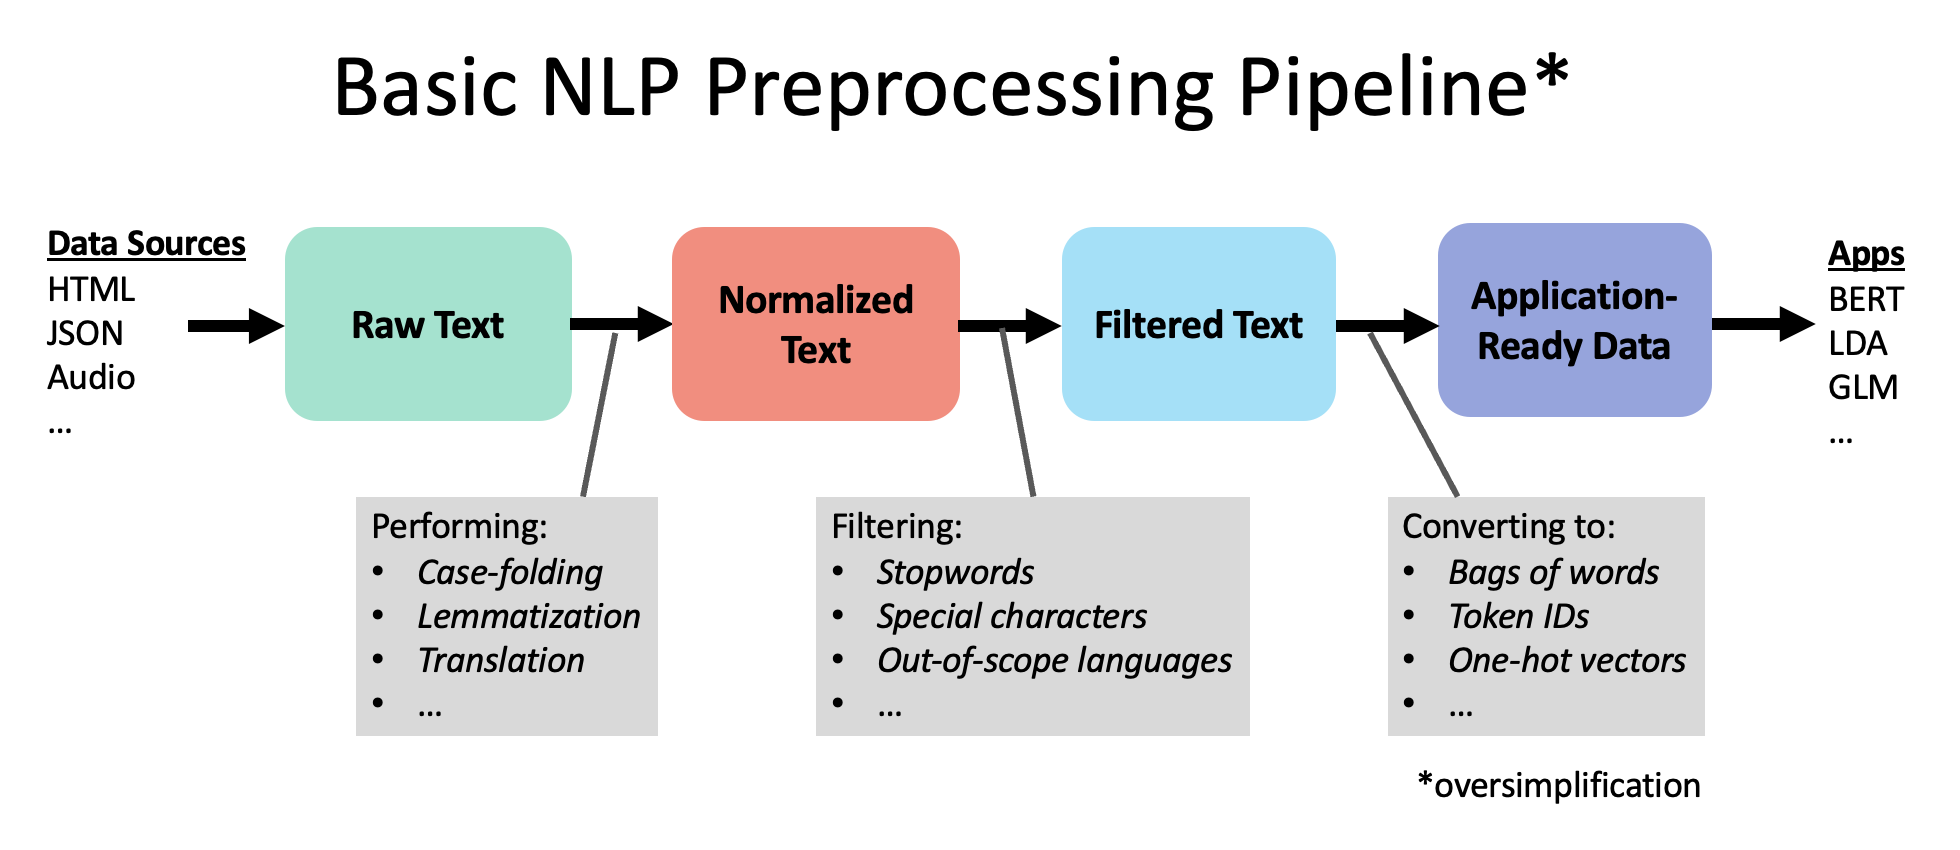

### What is the purpose of preprocessing? 🤔



- **Normalization**: what non-identical strings should be treated as the same? 
  - *Aids generalization*
- **Filtering**: which strings or characters shouldn't be included? 
  - *Removes "noise"* (can *only* be defined in context of an application)
- **Preparation for application input**: how to produce the expected input format for our main tasks? 
  - *Allows use of existing tools*
- What else?

### Which steps do we actually need to do? 🤔

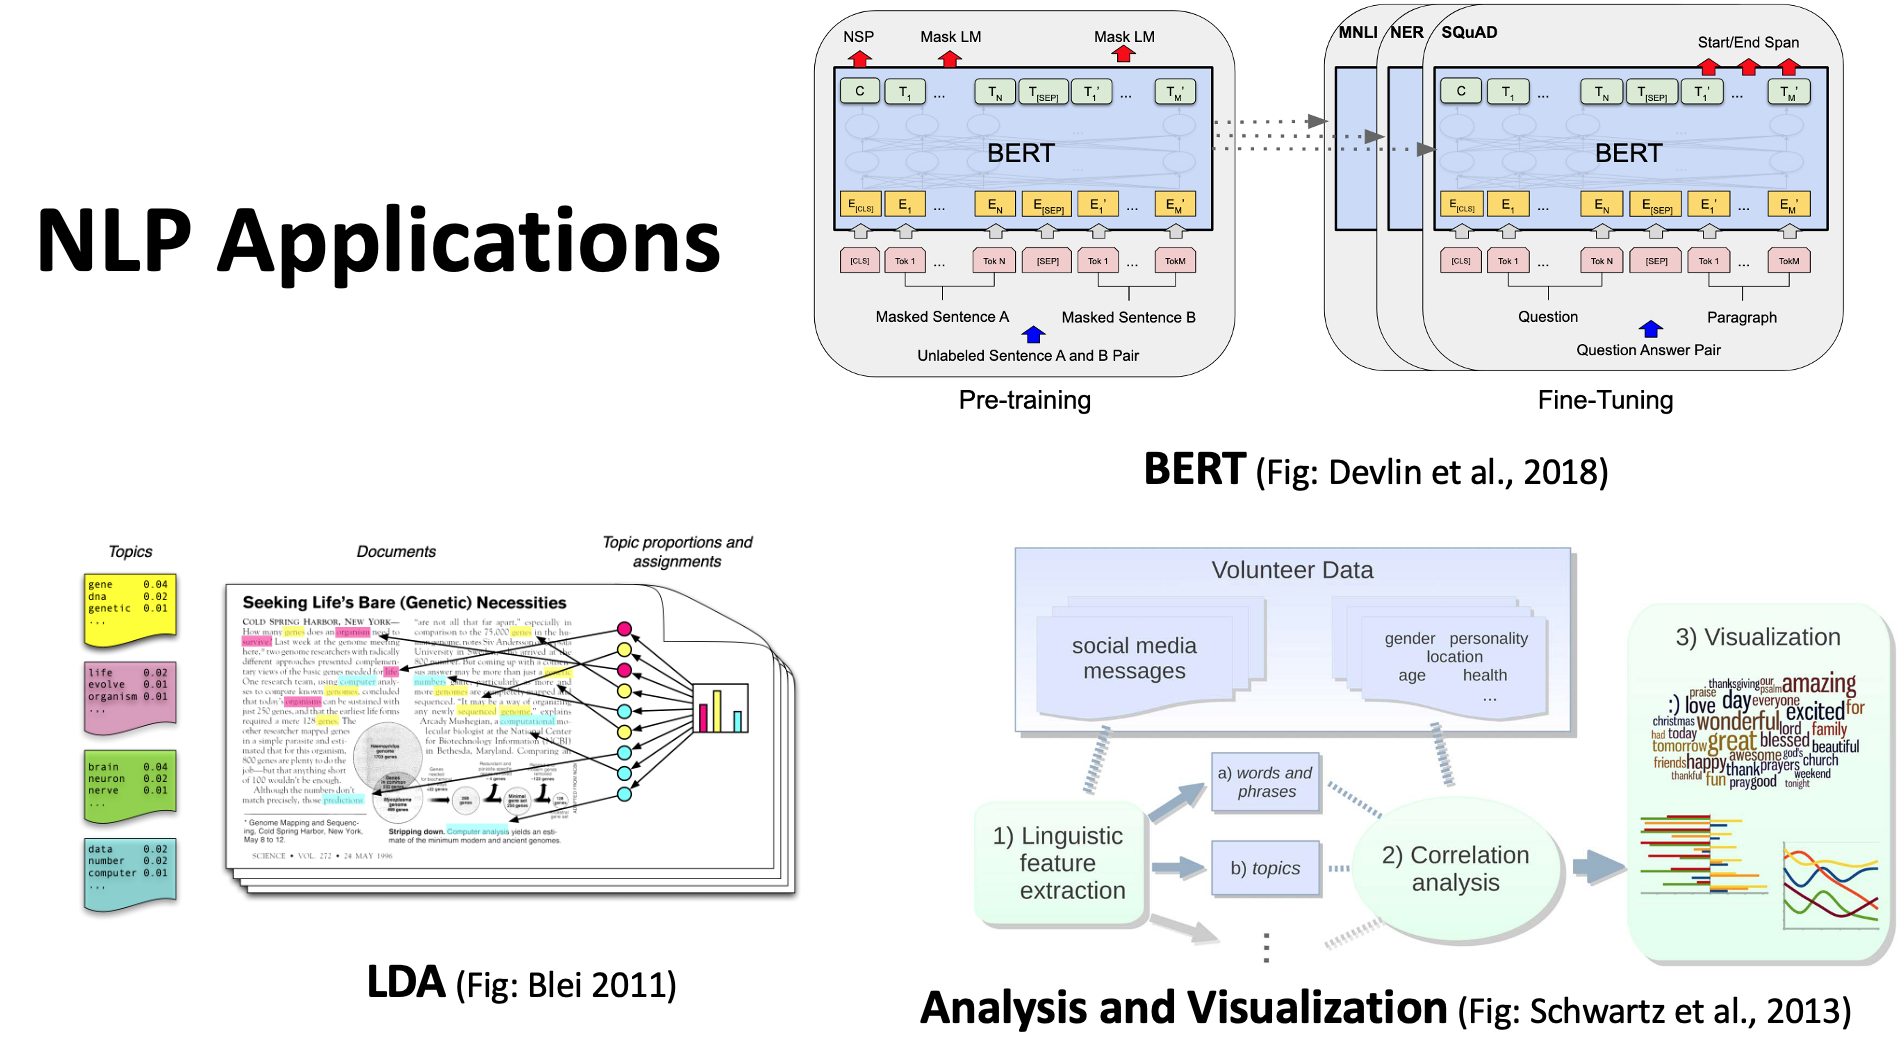

#### *Preprocessing should serve your end application!*

##### **Models**
- **BERT-based models** typically have their own pre-packaged tokenizers which rely on full sentences as input.
- **Topic Models** require bag-of-words (BOW) representations and benefit from stopword removal and normalization
- **Linear Models** might require conversion of text into features of interest like BOW or sentence embeddings, but also precomputed features like sentence length, emotional intensity, entity mentions, style or topic features, etc.
- What else?

##### **Application areas**
- You will lose information when you preprocess!
- Do you need to be able to differentiate between... (maybe avoid this)
  - first and third person? (stopword removal)
  - past and present tense? (lemmatization)
  - named entities and other nouns? (case-folding)
  - "person bits dog" and "dog bites person"? (BOW)
  - What else?

### Python libraries for **general** text preprocessing 📑 ➡️ 💻 ➡️ 📊


A lot of what we might want is standard in Python!

In [ ]:
# Let's write a super simple function to do some common operations

def super_simple_preprocess(text):
  # lowercase
  text = text.lower()
  # remove non alphanumeric characters
  text = re.sub('[^A-Za-z0-9 ]+','', text)
  return text

In [ ]:
before_and_after("Hello, world!", super_simple_preprocess)

#### **NLTK**: Natural Language Toolkit

In [ ]:
# NLTK has some useful functions to add
# NLTK is good for learning about NLP and how the basics work
# For example, let's remove stopwords and perform stemming
# in addition to the steps we had before

# Don't put these in the function - they don't need to run every time
stemmer = nltk.stem.porter.PorterStemmer()
stoplist = nltk.corpus.stopwords.words('english')

def nltk_preprocess(text, stemmer=stemmer, stoplist=stoplist):
  text = super_simple_preprocess(text)
  tokens = text.split()
  processed_tokens = [stemmer.stem(t) for t in tokens if t not in stoplist]
  return ' '.join(processed_tokens)

In [ ]:
before_and_after("Now, let's try using NLTK...", nltk_preprocess)

#### **SpaCy**: "Industrial-strength NLP in Python"

In [ ]:
# SpaCy is fast and good for building applications
# Can do many of the same things as NLTK

# load a spacy model
# disable the pieces of the default pipeline that we don't want right now
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# let's add lemmatization and stopword removal with spacy
def spacy_preprocess(text, nlp=nlp):
  text = super_simple_preprocess(text)
  processed_tokens = [t.lemma_ for t in nlp(text) if not t.is_stop]
  return ' '.join(processed_tokens)

In [ ]:
before_and_after("Anyway, let's try using SpaCy...", spacy_preprocess)

#### Differences?

##### Stopword lists

One difference between these libaries is that they relt on different stopword lists. It's important to have an idea about what words are in these lists and make sure you aren't removing anything unexpected!

In [ ]:
print("In NLTK but not SpaCY",set(stoplist) - set(nlp.Defaults.stop_words))
print("In SpaCy but not NLTK",set(nlp.Defaults.stop_words) - set(stoplist))

This is all for general text. What is different about social media text? 💬

# 3. Social media text data 💬

For this tutorial, we are going to use some real data from Twitter.

Since we want to show some examples, we avoid working with tweets that were not intended to be widely viewed (see [Davis and Jurgenson, 2013](https://www.tandfonline.com/doi/abs/10.1080/1369118X.2014.888458?journalCode=rics20)) by collecting recent tweets from very popular celebrities and politicians.

### Twitter Dataset

- The data we are going to use today was collected for this tutorial using [tweepy](https://www.tweepy.org/). It contains recent tweets from popular celebrity accounts. 

- You can access the data [here](https://github.com/steve-wilson/nlpcss201-sm-preprocessing), but if you ran the main "Setup" cell at the beginning, it has already been downloaded.

- We won't get into the details of the Twitter API today. You can learn more about collecting your own data from the [Twitter API documentation](https://developer.twitter.com/en/docs/twitter-api). You will need to apply for a (free) developer account to use the API.

### Check some sample data

Let's take a look at the general structure of the data.

- user: username (without the leading @)
- user_type: manually given label just for categorization examples
- tweet_id: unique number associated with each tweet
- created_at: time that the tweet was tweeted
- text: the actual text of the tweet
- expanded_urls: un-shortened version of t.co urls when available, separated by a single space

In [ ]:
# Take a look at the data
file_name = "celebrity_tweets.csv"
df = pd.read_csv(file_name)
df.head(5)

In [ ]:
# Let's see what else is in the dataset (some pre-selected examples)
row_ids = [51, 2054, 7661, 12525, 29235, 30183, 50312, 52006, 54902]
for row_id in row_ids:
  row = df.iloc[row_id]
  print(f"@{row.user}:")
  print(row.text)
  if type(row.expanded_urls) == str:
    print('Expanded URLs:',row.expanded_urls)
  print('---')

What do we notice? What things might not be handled by the standard pipelines?

📝 Double-click and make a list here 📝

# 4. Social media preprocessing 🧑‍🔧

#### Python libraries 📑 ➡️ 🐍 ➡️ 📊

Social media specific preprocessing libraries in Python! Let's try some and compare to the traditional ones.

##### Tweet-preprocessor

In [ ]:
sample_text = 'Preprocessor is #awesome 👍 https://github.com/s/preprocessor'
print("Our SpaCy processor:\t\t",spacy_preprocess(sample_text))
print("Tweet-preprocessor clean:\t",tweet_preprocessor.clean(sample_text))
print("Tweet-preprocessor tokenize:\t",tweet_preprocessor.tokenize(sample_text))

###### Why would we want those special tokens like \$HASHTAG\$ and \$EMOJI\$?

*Provides a way for downstream applications to know there was a certain feature without treating each instance of it as a separate token. A form of normalization.*

##### NLTK tweet tokenizer

In [ ]:
# NLTK actually has a special tokenizer for dealing with tweets
tt = nltk.tokenize.TweetTokenizer()
sample_text = "Here is another sample #Twitter post 😎. :) https://twitter.com"
print(tt.tokenize(sample_text))
print(nltk.word_tokenize(sample_text))

##### twitter-text-python

In [ ]:
# Uses built-in patterns to extra twitter specific features from text
p = ttp.Parser()
sample_text = "@burnettedmond, you now support #IvoWertzel's tweet parser! https://github.com/edmondburnett/twitter-text-python"
result = p.parse(sample_text)
print(result.reply)
print(result.users)
print(result.tags)
print(result.urls)

##### Ekphrasis

This library handles all kinds of facets of Twitter data and is a fairly complete solution!

In [ ]:
# showing the example from https://github.com/cbaziotis/ekphrasis

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

# adding a simple wrapper that we can use later if we want
def ekphrasis_processor(text, text_processor=text_processor):
  return ' '.join(text_processor.pre_process_doc(text))

In [ ]:
sentences = [
    "CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries :)))",
    "I saw the new #johndoe movie and it suuuuucks!!! WAISTED $10... #badmovies :/",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/."
]

for s in sentences:
    print(" ".join(text_processor.pre_process_doc(s)))

- Pretty cool! Notice how certain spans of text have been tagged with xml-style tags.

- Hashtags have also been split into individual parts.

- This library also deals with things like repetition and elongation

### Case studies
Let's look more closely what we can do with these social media text features in our preprocessing pipeline:
- Emoji
- Hashtags
- URLs

#### Emoji 😁

##### How are emoji actually represented?

- Digital text (even these letters you are reading now) is actually represented as a sequence of binary codes! 

- Your computer then translates these codes into the correct character.

- To make sure you see (roughly) the same text on different computers and applications, a standard mapping between binary codes and characters is needed!

- For the web, the [Unicode standard](https://en.wikipedia.org/wiki/List_of_Unicode_characters) is widely used and contains over 144,000 distinct characters.


In [ ]:
# Take this sequence of hexadecimal data as an example
# In some datasets, depending on the format that the data was saved in,
# you might see these strange looking sequences...
byte_sequence = b'\xf0\x9f\x94\xa5'
# This is a sequence of bytes in utf-8 format, let's decode to a string
byte_sequence.decode("UTF-8")

In [ ]:
# convert back to bytes
"🔥".encode("UTF-8")

In [ ]:
# or show the underlying code point 
f"{ord('🔥'):X}"

(verify this matches with the codepoint here: https://emojipedia.org/emoji/%F0%9F%94%A5/ )

^^^ Take a look at the URL itself! You can see the same f0 9f 95 a5 sequence from before

In [ ]:
# let's take a look at another one
'👨🏼‍🏫'.encode("UTF-8")

Why is this one so much longer?
- Many emoji can be modified! (E.g., hair, skin tone, etc.)
- These emoji are actually represented by multiple parts
  - The base code point
  - Modifiers

In [ ]:
# can we see the individual parts?
part1 = '👨🏼‍🏫'.encode("UTF-8")[:8]
part2 = '👨🏼‍🏫'.encode("UTF-8")[8:]
print(f'👨🏼‍🏫 = {part1.decode("UTF-8")} + {part2.decode("UTF-8")}')

In [ ]:
# can we break these down even more??
part1 = '👨🏼‍🏫'.encode("UTF-8")[:4]
part2 = '👨🏼‍🏫'.encode("UTF-8")[4:8]
part3 = '👨🏼‍🏫'.encode("UTF-8")[8:]
print(f'👨🏼‍🏫 = {part1.decode("UTF-8")} + {part2.decode("UTF-8")} + {part3.decode("UTF-8")}')

In [ ]:
# for combining certain emoji,
# a special joining code is sometimes used, which is '\u200d'
joiner = '\u200d'.encode('UTF-8')
combined_emoji = '👨🏼'.encode("UTF-8") + joiner + '🏫'.encode("UTF-8")
print(combined_emoji.decode("UTF-8"))

In [ ]:
# let's make a function for breaking emoji down
# Python iterators already handle this very well
# We just need to remove the joiner, and variation selector
def emoji_split(e, joiner = '\u200d', 
                variation_selector=b'\xef\xb8\x8f'.decode('utf-8'),
                return_special_chars = False):
  parts = []
  for part in e:
    if part == joiner:
      if return_special_chars:
        parts.append(":joiner:")
    elif part == variation_selector:
      if return_special_chars:
        parts.append(":variation:")
    else:
      parts.append(part)
  return parts

# and a function to format it like an equation
def print_emoji_equation(e,show_special=True):
  print(f"{e} =",' + '.join(emoji_split(e,return_special_chars=show_special)))

In [ ]:
# test it out (feel free to try your own)
for e in ['👨🏼‍🏫','👨‍👩‍👦','🦹🏾‍♂️','🧑🏻‍⚖️','🇺🇸','🆒','❤️']:
  print_emoji_equation(e)

##### How can this help us during preprocessing?

One example: Studying skin-tone use in emoji (e.g., see [Robertson et al., 2021](https://arxiv.org/abs/2105.05887))

In [ ]:
# let's look at emoji usage for different users in our dataset
# using the nltk tweet tokenizer from before and the emoji library

tt = nltk.tokenize.TweetTokenizer()
user2emoji = collections.defaultdict(collections.Counter)

for index, row in df.iterrows():
  tokens = tt.tokenize(row.text)
  emojis = [t for t in tokens if t in emoji.UNICODE_EMOJI]
  user2emoji[row.user].update(collections.Counter(emojis))

In [ ]:
# Check the top 5 emoji *components* for each user
for user, emoji_counter in user2emoji.items():
  print(user)
  print(emoji_counter.most_common(5))

In [ ]:
# check the top skin-tone emoji for the user

def get_top_from_set(c, s):
  for item, count in c.most_common():
    if item in s:
      return item,count
  return '',0

skin_tones = set(['🏿','🏾','🏽','🏼','🏻'])
for user, emoji_counter in user2emoji.items():
  print(user, get_top_from_set(emoji_counter, skin_tones))

Note that skin tone modifiers have only been around since 2015 and supported at different times for different platforms. Not all datasets with emoji will include this.

##### Coverting emoji to plain text **strings**

- Another useful step might be converting emoji into plain text strings.

- For example, if you have an existing model that has the token 'pizza' as a feature, but not '🍕', we might choose to collapse these representations.

- Or, some models might not work well with emoji inputs and expect only strings of alphanumeric characters.

In [ ]:
# This is easy to do with the emoji library
# We can get the description for any emoji in English (or other languages)
emoji.demojize('🍕')

- Yet another option is to include both the text description and either
  - the fact the there was an emoji in the text
  - the specific emoji
- This can be useful for BOW representations and has been shown to help with tweet classification, see [Singh et al., 2019](https://aclanthology.org/N19-1214/)

In [ ]:
# this isn't exactly what we want...
emoji.demojize("Let's grab some lunch: 🍕 or 🍜 or 🍱?")

In [ ]:
# need to get each token and make copies of the emoji, then translate one
sample_text = "Let's grab some lunch: 🍕 or 🍜 or 🍱?"
tt = nltk.tokenize.TweetTokenizer()

def emoji_and_demoji(text, replace_emoji_with=None):
  tokens = tt.tokenize(text)
  final_tokens = []
  for t in tokens:
    if t in emoji.UNICODE_EMOJI:
      if replace_emoji_with:
        final_tokens.append(replace_emoji_with)
      else:
        final_tokens.append(t)
      final_tokens.append(emoji.demojize(t).strip(':'))
    else:
      final_tokens.append(t)
  return final_tokens

print(emoji_and_demoji(sample_text))
print(emoji_and_demoji(sample_text, replace_emoji_with="#EMOJI#"))

##### Emoji tokenization considerations

In [ ]:
# NLTK's tweet tokenizer will split skintone emoji apart
# spacymoji works much better if we want to keep the entire units

In [ ]:
testing_string = "test ✌🏽😍🔥"
nlp = spacy.load("en_core_web_sm", disable='ner')
nlp.add_pipe('emoji', first=True)
doc = nlp(testing_string)
print('Spacymoji:',[token.text for token in doc])
print('NLTK TweetTokenizer:',tt.tokenize(testing_string))

#### #Hashtags

We can do something similar to what we just did with emojis, but with hashtags


In [ ]:
# can handle this with a regular expression
sample_text = "I am feeling #good about this"
# match 2 groups, denoted by ():
# 1 is (#([^\s]+)) basically, a # followed by 1 or more non-whitespace characters
# 2 is ([^\s]+) just the 1 or more non-whitespace characters without the #
hashtag_duplicated_text = re.sub("(#([^\s]+))","\\1 \\2",sample_text)
print(hashtag_duplicated_text)

Why would we want both?
- Sometimes, the original hashtag has is own meaning, even different from the word (or words) that comprise it
- E.g., #metoo, #blacklivesmatter, #icebucketchallenge

Another option: use corpus statistics
- If a hashtag is used more than $N$ times in the entire corpus, don't try to split it

We also saw earlier that Ekphrasis can perform hashtag splitting (this is based on the Viterbi algorithm, see [here for more on that](http://norvig.com/ngrams/ch14.pdf))

In [ ]:
sample_text = "I am feeling #somekindaway about this"
print(text_processor.pre_process_doc(sample_text))

Can we do better?
- Maddela, Xu, and Preot ̧iuc-Pietro used a [neural network model for hashtag segementation](https://aclanthology.org/P19-1242.pdf) that outperforms a standard Viterbi-based approach

#### https:// URLs .com

What kind of information might we want from urls?

##### Normalizing to the domain level

In [ ]:
url_text = "https://aclanthology.org/events/acl-2021/#2021-acl-long"
parsed_url = urllib.parse.urlparse(url_text)
parsed_url.netloc

In [ ]:
# Which domains were most common on our dataset?

user2domains = collections.defaultdict(collections.Counter)

def get_domain_from_url1(url):
  return urllib.parse.urlparse(url).netloc

for index, row in df.iterrows():
  if type(row.expanded_urls) == str:
      urls = row.expanded_urls.split()
      domains = [get_domain_from_url1(url) for url in urls]
      user2domains[row.user].update(collections.Counter(domains))

In [ ]:
# Check the top 5 domains for each user
for user, domain_counter in user2domains.items():
  print(user)
  print(domain_counter.most_common(5))

How might this be useful? One example: identifying whether accounts are typically sharing news from more *reliable* or *unreliable* sources (see [Liu et al., 2015](https://dl.acm.org/doi/10.1145/2806416.2806651)).

##### Retrieving more text by following URL

You might also decide to follow URLs and collect the text at the resulting page.
- Please keep in mind that making many requests in a short period of time can cause web servers to block you!

In [ ]:
# Get data from a webpage
link = "https://docs.python.org/3/tutorial/index.html"

f = urllib.request.urlopen(link)
webpage_contents = f.read()
f.close()
print(webpage_contents)

In [ ]:
# clean the html using beautifulsoup
print(BeautifulSoup(webpage_contents, "lxml").text)

Then you could process that data, extract additional features, identify topics, etc., and link that information back to the original tweet.

### Putting it together

Some setup for the tokenizer

In [ ]:
# make a custom processor from ekphrasis that just splits hashtags
# This takes some time to load so put it here, that way we don't have
# to run it again every time we change something else
hashtag_segmenter = TextPreProcessor(segmenter="twitter", unpack_hashtags=True)

In [ ]:
# get a set of punctuation
punct_set = set(string.punctuation + '''…'"`’”“'''  + '️')
# use spacy for tokenization
nlp = spacy.load("en_core_web_sm", disable=['ner','parser','lemmatizer'])
nlp.add_pipe('emoji', first=True)

# get default pattern for tokens that don't get split
re_token_match = spacy.tokenizer._get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match
def spacy_tokenize(text,nlp=nlp):
  return[token.text for token in nlp(text)]
# use SpaCy stoplist
stoplist = set(nlp.Defaults.stop_words)

In [ ]:
# Let's make a basic preprocessing function that pulls together multiple pieces
# of what we have talked about so far

# Note: this is not a perfect solution, just something to get you started!
def example_preprocessor(text, tokenize=spacy_tokenize, 
                         hashtag_segmenter=hashtag_segmenter,
                         punct_set=punct_set, stoplist=stoplist):

  # lowercase
  text = text.lower()
  # tokenize
  tokens = tokenize(text)
  updated_tokens = []
  # set different behavior for different kinds of tokens
  for t in tokens:
    # split emoji into components
    if t in emoji.UNICODE_EMOJI:
      updated_tokens += emoji_split(t)
    # keep original hashtags and split them into words
    elif t.startswith('#'):
      updated_tokens += [t]
      updated_tokens += hashtag_segmenter.pre_process_doc(t).split()
    # remove user mentions
    elif t.startswith('@'):
      pass
    # remove urls because we will get them from the expanded_urls field anyways
    # remove single punctuation markers
    elif t.startswith('http') or t in punct_set:
      pass
    # skip stopwords
    elif t and t not in stoplist:
      updated_tokens += [t]
  return ' '.join(updated_tokens)

In [ ]:
# try it out
sample_tweet = "Hi, @SteveWilsonNLP This is an #exampletweet https://steverw.com"
before_and_after(sample_tweet,example_preprocessor)

In [ ]:
# or use something like ekphrasis for a more off-the-shelf solution
before_and_after(sample_tweet,ekphrasis_processor)

# 5. Preprocesing sandbox 🧑‍🔬

##### Catch up

If you didn't run the previous cells but want to jump in now, run this block
Note: Make sure you have uploaded the celebrity_tweets.csv file

In [ ]:
# imports
import collections
import math
import random
import re
import requests
import sklearn
import string
import urllib

# some NLP libraries that can help us with preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# for coloring out outputs
from termcolor import colored
# for comparing strings
import difflib

import pandas as pd
from bs4 import BeautifulSoup

! pip install spacymoji
import spacymoji

! pip install -U pip setuptools wheel
! pip install -U spacy
! python -m spacy download en_core_web_sm

import spacy
! pip install tweet_preprocessor
import preprocessor as tweet_preprocessor
! pip install twitter-text-python
from ttp import ttp
! pip install emoji
import emoji
! pip install ekphrasis
import ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
stemmer = nltk.stem.porter.PorterStemmer()
stoplist = set(nltk.corpus.stopwords.words('english'))
tt = nltk.tokenize.TweetTokenizer()
hashtag_segmenter = TextPreProcessor(segmenter="twitter", unpack_hashtags=True)
punct_set = set(string.punctuation + '''…'"`’”“''')
def emoji_split(e, joiner = '\u200d', 
                variation_selector=b'\xef\xb8\x8f'.decode('utf-8'),
                return_special_chars = False):
  parts = []
  for part in e:
    if part == joiner:
      if return_special_chars:
        parts.append(":joiner:")
    elif part == variation_selector:
      if return_special_chars:
        parts.append(":variation:")
    else:
      parts.append(part)
  return parts
def before_and_after(text, method, kwargs={}):

  # get the before and after, then compare them with difflib's SequenceMatcher
  before = text
  after = method(text,**kwargs)
  if type(after) == list:
    after = ' '.join(after)
  diffs = difflib.SequenceMatcher(None, before, after)

  # This part takes a string and some sections that do match the other string
  # but highlights the parts that *don't* match
  def print_highlight_nonmatching(text, text_id, matches, hl_func):
    current = 0
    for match in matches:
      nonmatching_count = match[text_id] - current
      # some part of the string didn't match the other, 
      # need to print it with hl_func
      if nonmatching_count:
        substring_end = current + nonmatching_count
        print(hl_func(text[current:substring_end]),end='')
        current = substring_end
      # now print the part that *did* match without any color effects
      substring_end = current + match.size
      print(text[current:substring_end],end='')
      current = substring_end
    # print a blank line between the two
    print()

  # this will get the sequences that did match between the two strings
  matches = diffs.get_matching_blocks()
  hl_func_red = lambda x: colored(x,'red')
  hl_func_blue = lambda x: colored(x,'blue')

  # now use this to show the before and after with changes highlighted
  print("BEFORE: ",end="")
  print_highlight_nonmatching(before, 0, matches, hl_func_red)
  print("AFTER:  ",end="")
  print_highlight_nonmatching(after, 1, matches, hl_func_blue)
# get dataset from github
dataset_url = "https://raw.githubusercontent.com/steve-wilson/nlpcss201-sm-preprocessing/main/celebrity_tweets_no_rts.csv"
r = requests.get(dataset_url)
with open('celebrity_tweets.csv','wb') as output_file:
  output_file.write(r.content)
file_name = "celebrity_tweets.csv"
df = pd.read_csv(file_name)

# get a set of punctuation
punct_set = set(string.punctuation + '''…'"`’”“'''  + '️')
# use spacy for tokenization
nlp = spacy.load("en_core_web_sm", disable=['ner','parser','lemmatizer'])
nlp.add_pipe('emoji', first=True)

# get default pattern for tokens that don't get split
re_token_match = spacy.tokenizer._get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match
def spacy_tokenize(text,nlp=nlp):
  return[token.text for token in nlp(text)]
# use SpaCy stoplist
stoplist = set(nlp.Defaults.stop_words)

##### Customize your preprocessing function

Start with this example below and modify to your heart's content:

In [ ]:
# (optionally) use this block to do any custom setup for your model
# e.g., installing other libraries, loading resources, etc.
# uncomment below and modify, otherwise these defaults will be used

# use spacy for tokenization
#nlp = spacy.load("en_core_web_sm", disable='ner')
#nlp.add_pipe('emoji', first=True)
# get default pattern for tokens that don't get split
#re_token_match = spacy.tokenizer._get_regex_pattern(nlp.Defaults.token_match)
# add your patterns (here: hashtags and in-word hyphens)
#re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"
#def spacy_tokenize(text,nlp=nlp):
#  return[token.text for token in nlp(text)]
# make a custom processor from ekphrasis that just splits hashtags
#hashtag_segmenter = TextPreProcessor(segmenter="twitter", unpack_hashtags=True)
# get a set of punctuation
#punct_set = set(string.punctuation + '''…'"`’”“''' + '️')
# use SpaCy stoplist
#stoplist = set(nlp.Defaults.stop_words)

In [ ]:
def my_preprocessor(text, tokenize=spacy_tokenize, 
                         hashtag_segmenter=hashtag_segmenter,
                         punct_set=punct_set, stoplist=stoplist):

  # lowercase
  text = text.lower()
  # tokenize
  tokens = tokenize(text)
  updated_tokens = []
  # set different behavior for different kinds of tokens
  for t in tokens:
    # split emoji into components
    if t in emoji.UNICODE_EMOJI:
      updated_tokens += emoji_split(t)
    # keep original hashtags and split them into words
    elif t.startswith('#'):
      updated_tokens += [t]
      updated_tokens += hashtag_segmenter.pre_process_doc(t).split()
    # remove user mentions
    elif t.startswith('@'):
      pass
    # remove urls because we will get them from the expanded_urls field anyways
    # and remove single punctuation markers
    elif t.startswith('http') or t in punct_set:
      pass
    # skip stopwords and empty strings, include anything else
    elif t and t not in stoplist:
      updated_tokens += [t]
  return ' '.join(updated_tokens)

In [ ]:
# try it out on your own text (replace sample_tweet below with whatever you like)
sample_tweet = "@You your turn to #experiment with 🤖 text preprocessing..."
before_and_after(sample_tweet,my_preprocessor)

In [ ]:
# try it out on random real tweets
# set the random seed if you want to see the same tweets each time
random.seed(10)
max_row = df.shape[0]

print("'q' + ENTER to stop, ENTER to continue...")
try:
  while input("") != 'q':
    row = df.iloc[random.randint(0, max_row-1)]
    print(row.user)
    before_and_after(row.text, my_preprocessor)
except KeyboardInterrupt:
  print("Stopped by user.")

Below are 2 test cases that will use your preprocessor. Try them out with different versions of your method to see how the result changes!

### Test case 1: Top tokens for each user 📈
Sorted by tf-idf score (treating each user as a document)

In [ ]:
# set which function you want to use for preprocessing here
# using a lambda function like this can fix any parameters you want to use
# so feel free to modify those here as well (or set them to match your function)
tt = nltk.tokenize.casual.TweetTokenizer()

PREPROCESS = lambda x: my_preprocessor(x, tokenize=spacy_tokenize, 
                                       hashtag_segmenter=hashtag_segmenter,
                                       punct_set=punct_set, stoplist=stoplist)

In [ ]:
# count words for each user
user2tokens = collections.defaultdict(collections.Counter)
for index, row in df.iterrows():
  processed_tokens = PREPROCESS(row.text.strip())
  # your function can return a list of tokens or a string
  # if it's a string we will split on whitespace to get the tokens
  if type(processed_tokens) == str:
    processed_tokens = processed_tokens.split()
  user2tokens[row.user].update(collections.Counter(processed_tokens))

In [ ]:
for user, token_count in user2tokens.items():
  print(user)
  print(token_count.most_common(10))

### Test case 2: User type classification 🧑‍🎤🕺🏻🎭 
Using a sklearn Random Forest classification model with simple BOW features

In [ ]:
# prepare data
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing, utils
vectorizer = CountVectorizer(preprocessor=my_preprocessor)
corpus = df['text']
X = vectorizer.fit_transform(corpus)
Y_strings = df['user_type']
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y_strings)

In [ ]:
# shuffle and make train/test splits
train_size = 40000
X,Y = utils.shuffle(X,Y)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

In [ ]:
# train the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

In [ ]:
# check training set performance
train_preds = model.predict(X_train)
# training performance
print(sklearn.metrics.classification_report(y_train,train_preds))

In [ ]:
# check test set performance
test_preds = model.predict(X_test)
print(sklearn.metrics.classification_report(y_test,test_preds))

### Debrief

- What worked well?
- What problems did you run into, and how did you address them?
- What surprised you?
- What takeaways do you have from this tutorial?

# Further reading/viewing

- [Self-Representation on Twitter Using Emoji Skin Color Modifiers](https://www.aaai.org/ocs/index.php/ICWSM/ICWSM18/paper/download/17833/17080)

- [Race is not a skin tone, gender is not a haircut](https://www.youtube.com/watch?v=kaucJce8hhE&t=19s)

- [Multi-task Pairwise Neural Ranking for Hashtag Segmentation](https://aclanthology.org/P19-1242/)

- [Emotion helps Sentiment: A Multi-task Model for
Sentiment and Emotion Analysis](https://arxiv.org/pdf/1911.12569.pdf)

- [Rumor Detection and Classification for Twitter Data](https://arxiv.org/abs/1912.08926)

- [Role of Text Pre-processing in Twitter Sentiment Analysis](https://www.sciencedirect.com/science/article/pii/S1877050916311607)

- [Social and Emotional Correlates of Capitalization on Twitter](https://aclanthology.org/W18-1102.pdf)